In [5]:
#
# NOTE: This machine learning program is for predicting TC formation, using
#       input dataset in the NETCDF format. The program treats different
#       2D input fields as different channels of an image. This specific
#       program requires a set of 12 2D-variables (12-channel image) and
#       consists of three stages
#       - Stage 1: reading NETCDF input and generating (X,y) data with a
#                  given image sizes, which are then saved by pickle;
#       - Stage 2: import the saved pickle (X,y) pair and build a CNN model
#                  with a given training/validation ratio, and then save
#                  the train model under tcg_CNN.model.
#       - Stage 3: import the trained model from Stage 2, and make a list
#                  of prediction from normalized test data.
#
# INPUT: This Stage 2 script requires two specific input datasets that are
#        generated from Step 1, including
#        1. tcg_X.pickle: data contains all images of yes/no TCG events, each
#           of these images must have 12 channels
#        2. tcg_y.pickle: data contains all labels of each image (i.e., yes
#           or no) of TCG corresponding to each data in X.
#
#        Remarks: Note that each channel must be normalized separealy. Also
#        the script requires a large memory allocation. So users need to have
#        GPU version to run this.
#
# OUTPUT: A CNN model built from Keras saved under tcg_CNN.model
#
# HIST: - 27, Oct 22: Created by CK
#       - 01, Nov 22: Modified to include more channels
#       - 17, Nov 23: cusomize it for jupiter notebook
#       - 21, Feb 23: use functional model instead of sequential model  
#
# AUTH: Chanh Kieu (Indiana University, Bloomington. Email: ckieu@iu.edu)
#
#==========================================================================
import tensorflow as tf
import numpy as np
import pickle
import time
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard

In [7]:
#
# read in data output from Part 1
#
pickle_in = open("tcg_X.pickle","rb")
X = pickle.load(pickle_in)
pickle_in = open("tcg_y.pickle","rb")
y = pickle.load(pickle_in)
y = np.array(y)
number_channels=X.shape[3]
print('Input shape of the X features data: ',X.shape)
print('Input shape of the y label data: ',y.shape)
print('Number of input channel extracted from X is: ',number_channels)
#
# normalize the data before training the model
#
nsample = X.shape[0]
for i in range(nsample):
    for var in range(number_channels):    
        maxvalue = X[i,:,:,var].flat[np.abs(X[i,:,:,var]).argmax()]
        #print('Normalization factor for sample and channel',i,var,', is: ',abs(maxvalue))
        X[i,:,:,var] = X[i,:,:,var]/abs(maxvalue)
        maxnew = X[i,:,:,var].flat[np.abs(X[i,:,:,var]).argmax()]
        #print('-->After normalization of sample and channel',i,var,', is: ',abs(maxnew))
        #input('Enter to continue...')
print("Finish normalization...")

Input shape of the X features data:  (704, 30, 30, 12)
Input shape of the y label data:  (704,)
Number of input channel extracted from X is:  12
Finish normalization...


In [3]:
#
# test a range of loop for hyperparameter tuning. This is a test and have no impact to the rest of the
# code. 
#
dense_layers = [0, 5]
layer_sizes = [128, 256]
conv_layers = [3, 5]
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            print(dense_layer, layer_size, conv_layer, X.shape[1:])

0 128 3 (30, 30, 12)
0 128 5 (30, 30, 12)
0 256 3 (30, 30, 12)
0 256 5 (30, 30, 12)
5 128 3 (30, 30, 12)
5 128 5 (30, 30, 12)
5 256 3 (30, 30, 12)
5 256 5 (30, 30, 12)


In [11]:
#
# build a range of CNN models with different number of dense layers, layer sizes
# convolution layers to optimize the performance
#
dense_layers = [0]
layer_sizes = [32]
conv_layers = [3]
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print('--> Running configuration: ',NAME)

            inputs = keras.Input(shape=X.shape[1:])            
            x = layers.Conv2D(filters=layer_size,kernel_size=conv_layer,activation="relu",name="my_conv2d_1")(inputs)
            x = layers.MaxPooling2D(pool_size=2,name="my_pooling_1")(x)
            x = layers.Conv2D(filters=layer_size*2,kernel_size=conv_layer,activation="relu",name="my_conv2d_2")(x)
            x = layers.MaxPooling2D(pool_size=2,name="my_pooling_2")(x)
            x = layers.Conv2D(filters=layer_size*4,kernel_size=conv_layer,activation="relu",name="my_conv2d_3")(x)
            x = layers.MaxPooling2D(pool_size=2,name="my_pooling_3")(x)
            #x = layers.Conv2D(filters=256,kernel_size=conv_layer,activation="relu",name="my_conv2d_4")(x)
            #x = layers.MaxPooling2D(pool_size=2,name="my_pooling_4")(x)
            #x = layers.Conv2D(filters=256,kernel_size=conv_layer,activation="relu",name="my_conv2d_5")(x)
            x = layers.Flatten(name="my_flatten")(x)
            outputs = layers.Dense(1,activation="sigmoid",name="my_dense")(x)
            model = keras.Model(inputs=inputs,outputs=outputs,name="my_TCG_model")
            model.summary()
            keras.utils.plot_model(model)
            
            callbacks=[keras.callbacks.ModelCheckpoint("tcg_CNN.model",save_best_only=True)]
            model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
            history = model.fit(X, y, batch_size=90, epochs=30, validation_split=0.1, callbacks=callbacks)                        
#
# save the model for the final step
#
#model.save('tcg_CNN.model')

--> Running configuration:  3-conv-32-nodes-0-dense-1685562612
Model: "my_TCG_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 30, 30, 12)]      0         
                                                                 
 my_conv2d_1 (Conv2D)        (None, 28, 28, 32)        3488      
                                                                 
 my_pooling_1 (MaxPooling2D)  (None, 14, 14, 32)       0         
                                                                 
 my_conv2d_2 (Conv2D)        (None, 12, 12, 64)        18496     
                                                                 
 my_pooling_2 (MaxPooling2D)  (None, 6, 6, 64)         0         
                                                                 
 my_conv2d_3 (Conv2D)        (None, 4, 4, 128)         73856     
                                                         

2023-05-31 15:50:13.032152: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 24.61MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-31 15:50:13.039936: E tensorflow/stream_executor/cuda/cuda_dnn.cc:389] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2023-05-31 15:50:13.040049: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at conv_ops.cc:1120 : UNIMPLEMENTED: DNN library is not found.


UnimplementedError: Graph execution error:

Detected at node 'my_TCG_model/my_conv2d_1/Conv2D' defined at (most recent call last):
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_33411/309534642.py", line 32, in <cell line: 8>
      history = model.fit(X, y, batch_size=90, epochs=30, validation_split=0.1, callbacks=callbacks)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 250, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 225, in convolution_op
      return tf.nn.convolution(
Node: 'my_TCG_model/my_conv2d_1/Conv2D'
DNN library is not found.
	 [[{{node my_TCG_model/my_conv2d_1/Conv2D}}]] [Op:__inference_train_function_4099]

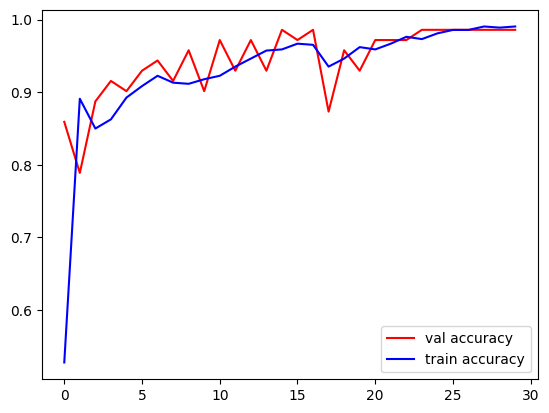

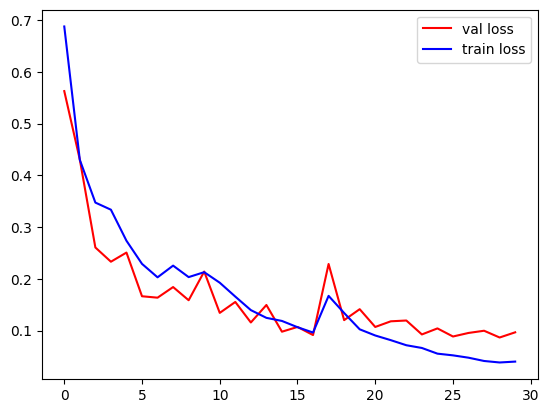

In [6]:
import matplotlib.pyplot as plt
#print(history.__dict__)
#print(history.history)
val_accuracy = history.history['val_accuracy']
accuracy = history.history['accuracy']
epochs = history.epoch 
plt.plot(epochs,val_accuracy,'r',label="val accuracy")
plt.plot(epochs,accuracy,'b',label="train accuracy")
plt.legend()

plt.figure()
val_loss = history.history['val_loss']
loss = history.history['loss']
plt.plot(epochs,val_loss,'r',label="val loss")
plt.plot(epochs,loss,'b',label="train loss")
plt.legend()
plt.show()